1.检查CUDA是否安装成功,是否有可用的GPU,如果没有用CPU运行

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2.数据集的准备,做归一化和标准化，划分训练集和测试集，以及batch的大小等参数的设置。

In [2]:
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize((0.5,), (0.5,))  # 归一化处理
])

# 加载训练数据集和测试数据集
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 使用 DataLoader 加载数据集
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

3.定义卷积层

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # 定义网络层
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 输入1个通道，输出32个通道，卷积核大小为3x3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 输入32个通道，输出64个通道，卷积核大小为3x3
        self.fc1 = nn.Linear(7 * 7 * 64, 128)  # 全连接层，输入大小为 7x7x64（经过池化后的图像大小）
        self.fc2 = nn.Linear(128, 10)  # 输出10个类别（对应0-9）

    def forward(self, x):
        # 定义前向传播过程
        x = F.relu(self.conv1(x))  # 卷积层 + 激活函数
        x = F.max_pool2d(x, 2)  # 最大池化
        x = F.relu(self.conv2(x))  # 卷积层 + 激活函数
        x = F.max_pool2d(x, 2)  # 最大池化
        x = x.view(-1, 7 * 7 * 64)  # 展平操作，将图像从二维变为一维向量
        x = F.relu(self.fc1(x))  # 全连接层 + 激活函数
        x = self.fc2(x)  # 输出层
        return x


4.模型实例化，并将模型移到合适的设备（GPU 或 CPU）

In [4]:
model = CNNModel().to(device)

5.打印模型摘要

In [5]:
from torchinfo import summary
# (batch_size=64, channels=1, height=28, width=28)
summary(model, input_size=(64, 1, 28, 28)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [64, 10]                  --
├─Conv2d: 1-1                            [64, 32, 28, 28]          320
├─Conv2d: 1-2                            [64, 64, 14, 14]          18,496
├─Linear: 1-3                            [64, 128]                 401,536
├─Linear: 1-4                            [64, 10]                  1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
Total mult-adds (M): 273.85
Input size (MB): 0.20
Forward/backward pass size (MB): 19.34
Params size (MB): 1.69
Estimated Total Size (MB): 21.23

6.定义损失函数和优化器

In [6]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 使用Adam优化器


7.训练模型

In [7]:

from tqdm import tqdm 

# 用于记录每个epoch的损失和准确率
train_losses = []
train_accuracies = []

num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # 设置模型为训练模式
    running_loss = 0.0
    correct = 0
    total = 0

    # 使用 tqdm 包装 trainloader 来显示进度条
    for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移到合适的设备
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # 计算损失

        # 反向传播和优化
        optimizer.zero_grad()  # 清零梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        # 统计损失和准确率
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # 获取预测的类别
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/5: 100%|██████████| 938/938 [00:07<00:00, 124.40batch/s]


Epoch 1/5, Loss: 0.1609, Accuracy: 95.21%


Epoch 2/5: 100%|██████████| 938/938 [00:08<00:00, 105.25batch/s]


Epoch 2/5, Loss: 0.0450, Accuracy: 98.68%


Epoch 3/5: 100%|██████████| 938/938 [00:08<00:00, 114.26batch/s]


Epoch 3/5, Loss: 0.0300, Accuracy: 99.03%


Epoch 4/5: 100%|██████████| 938/938 [00:08<00:00, 107.31batch/s]


Epoch 4/5, Loss: 0.0228, Accuracy: 99.26%


Epoch 5/5: 100%|██████████| 938/938 [00:09<00:00, 100.54batch/s]

Epoch 5/5, Loss: 0.0170, Accuracy: 99.45%


8.测试模型

In [8]:
model.eval()  # 设置模型为评估模式
correct = 0
total = 0
with torch.no_grad():  # 在测试时不计算梯度
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)  # 将数据移到合适的设备
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 99.14%


9.绘制训练损失和准确率曲线

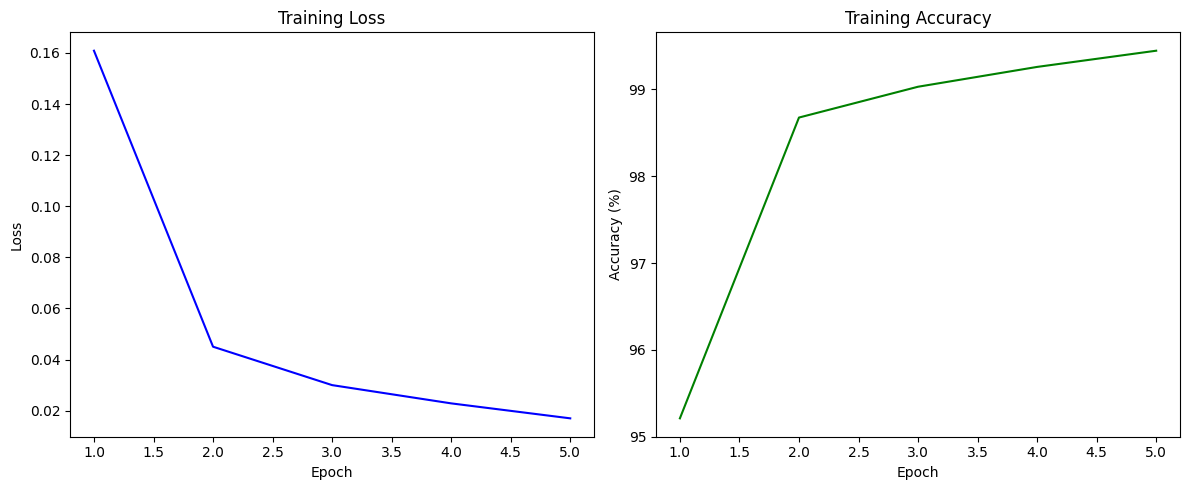

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 绘制训练损失
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# 绘制训练准确率
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()